# Домашнее задание №5
*Задание выполнил* **Чащин Артем Максимович**

*Курс:* **3**, *группа:* **МФТИ-1**

**[GitHub](https://github.com/alexvilno/PSU_TIMESERIES/tree/HW2)**

**[Telegram](https://t.me/artemchashchin)**

## Оглавление
* [Импорт данных](#import)
* [Визуализация выборки](#visual)
* [Предсказываем временной ряд деревом](#tree)
* [Предсказываем временной ряд случайным лесом](#forest)
* [Ищем выбросы с помощью изолированного дерева](#isolatedtree)

### Импорт данных <a id="import"></a>

In [1]:
import os
import pandas as pd
import numpy as np

from os import path
from matplotlib import pyplot as plt
from dotenv import load_dotenv

In [2]:
load_dotenv(dotenv_path='../.env')

True

Импортируем данные и посмотрим *описательную статистику* выборки

In [3]:
file_path = os.getenv('PATH_TO_DATA')

sales_df = pd.read_csv(path.join(os.sep, file_path, 'data.csv'))
sales_df.describe()

,Unnamed: 0,x
count,120.000000,120.000000
mean,60.500000,713.749200
std,34.785054,174.050535
min,1.000000,215.187000
25%,30.750000,633.284000
50%,60.500000,733.300000
75%,90.250000,833.147000
max,120.000000,1006.852000


### Визуализация выборки <a id="visual"></a>

Функция, которая добавляет легенду на график

In [4]:
def plot_assignation(axp, data, xlabel, ylabel, title1, periods):
    axp.plot(data)
    axp.set_xlabel(xlabel)
    axp.set_ylabel(ylabel)
    axp.set_title(title1)
    axp.set_xticks(np.arange(0, len(sales_df['x']) + 1, 12))
    axp.set_xticklabels(np.arange(periods + 1))

В соответсвтии с моими данными я визуализирую выборку на графике и добавляю его легенду

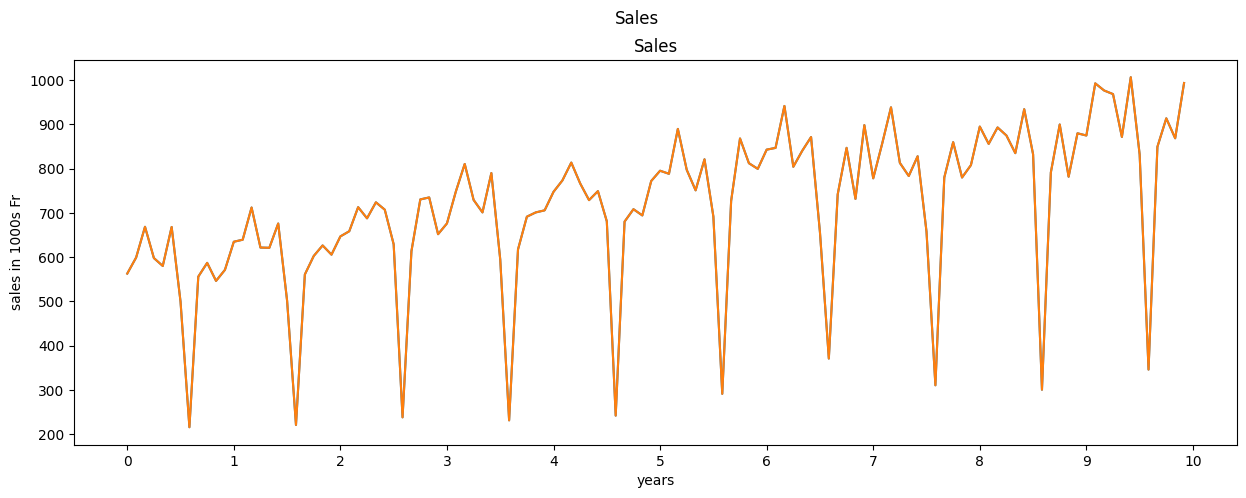

In [5]:
#выборка по 10 годам
period = 10

fig, axs = plt.subplots(1,1,figsize=(15,5))
fig.suptitle('Sales')
plot_assignation(axs, sales_df["x"], "years","sales in 1000s Fr","Sales", period)
axs.plot(sales_df['x'])

### Предсказываем временной ряд деревом <a id="tree"></a>

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from numpy import asarray

In [7]:
n_vars = 1 if type(sales_df) is list else sales_df.shape[1]
cols = list()
for i in range(1, 0, -1):
    cols.append(sales_df.shift(i))
for i in range(0, 1):
    cols.append(sales_df.shift(-i))
# put it all together
agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
list_for_forecast = agg.values

In [8]:
def decision_tree_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = DecisionTreeRegressor(random_state=0)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

### Предсказываем временной ряд случайным лесом <a id="forest"></a>

In [9]:
def random_forest_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [10]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = random_forest_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

error = mean_absolute_error(test[:, -1], predictions)
print("Random Forest error: ", error)

Random Forest error:  124.40941007317043


In [11]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

def SMAPE(forecast: pd.DataFrame, forecast_pred: pd.DataFrame) -> float:
    return np.sum((np.abs(forecast - forecast_pred)) / ((np.abs(forecast) + np.abs(forecast_pred)) / 2)) * 100 / len(forecast)

def print_metrics(true: pd.DataFrame, pred: list):
    print("RMSE:", np.sqrt(mean_squared_error(true, pred)))
    print("MAPE:", mean_absolute_percentage_error(true, pred))
    print("SMAPE:", SMAPE(true, pred))
    print("MAE:", mean_absolute_error(true, pred))
    print("R2: ", r2_score(true, pred))

In [12]:
print_metrics(test[:, -1], predictions)

RMSE: 171.28601494533183
MAPE: 0.21285592993378027
SMAPE: 17.83076959475009
MAE: 124.40941007317043
R2:  0.015099193269814681


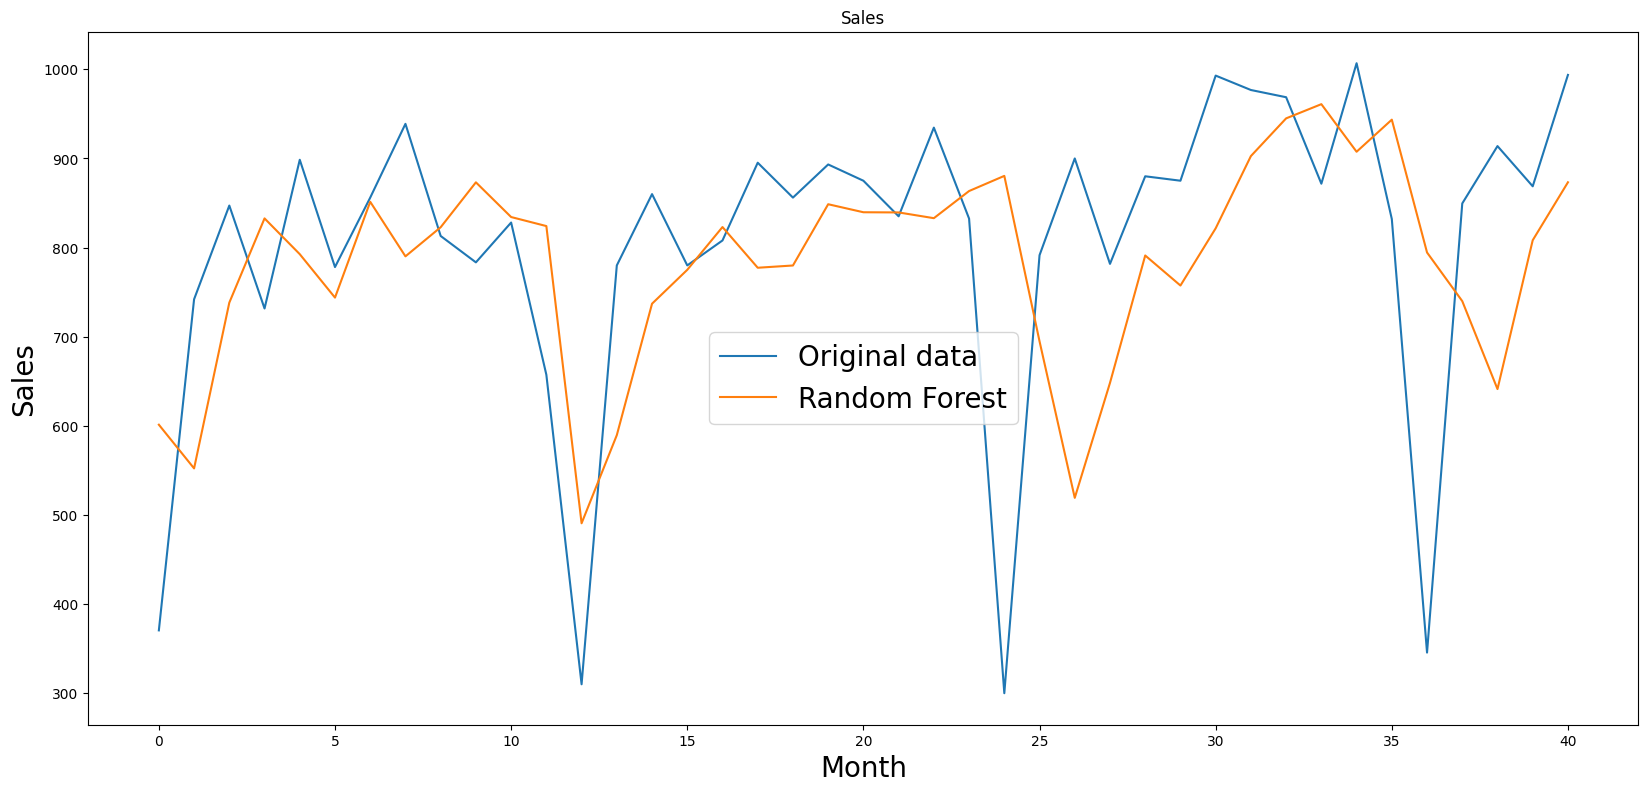

In [13]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Random Forest')
plt.legend(fontsize="20")
plt.title('Sales')
plt.ylabel('Sales', fontsize="20")
plt.xlabel('Month', fontsize="20")
plt.show()

In [14]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = decision_tree_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

Посмотрим на метрики решающего дерева

In [15]:
print("Decision Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Decision Forest metrics: 
RMSE: 240.61012330810496
MAPE: 0.2640514963624419
MAE: 163.34458536585365
R2:  -0.94346388088311


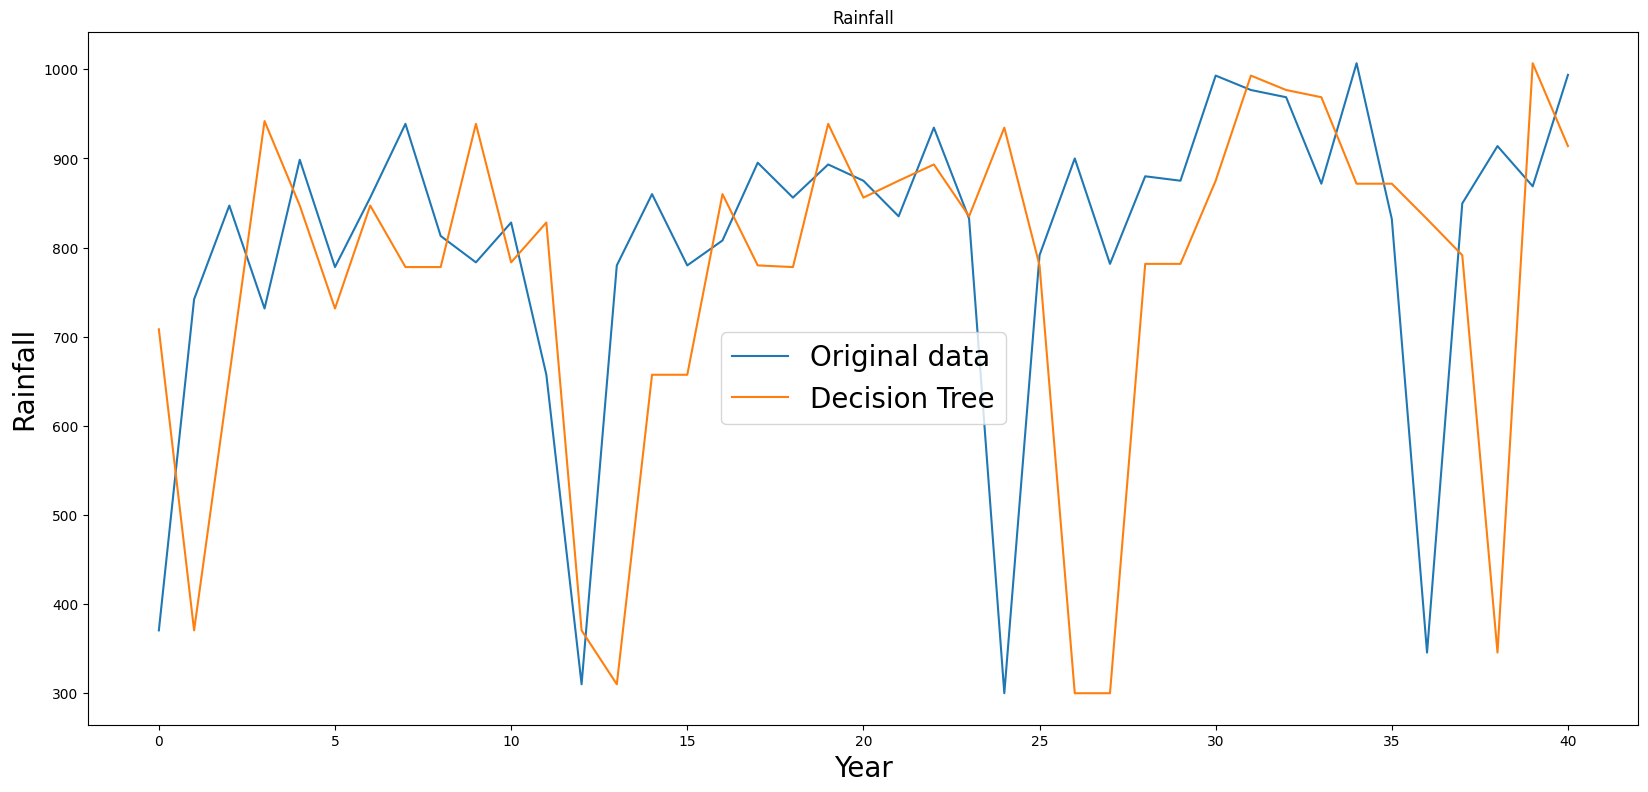

In [16]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Decision Tree')
plt.legend(fontsize="20")
plt.title('Rainfall')
plt.ylabel('Rainfall', fontsize="20")
plt.xlabel('Year', fontsize="20")
plt.show()

### Ищем выбросы с помощью изолированного дерева <a id="isolatedtree"></a>

In [17]:
from sklearn.ensemble import IsolationForest

В качестве модели используем изолированное дерево

In [18]:
model = IsolationForest(contamination=0.004)
model.fit(sales_df[['x']])

IsolationForest(contamination=0.004)

Ищем выбросы

In [19]:

sales_df["outliers"] = pd.Series([["no", "yes"][x == -1] for x in model.predict(sales_df[["x"]])])

/var/folders/ns/8k4fm20x1_g6s3_88nzjddf00000gn/T/ipykernel_49923/1131508344.py:1: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  sales_df["outliers"] = pd.Series([["no", "yes"][x == -1] for x in model.predict(sales_df[["x"]])])


In [20]:
sales_df['x'][sales_df["outliers"] == "yes"]

113    1006.852
Name: x, dtype: float64

Посмотрим на визуализацию

In [21]:
import plotly.express as px

fig = px.scatter(sales_df.reset_index(), x='index', y='x', color='outliers')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()